# XGBoost Parameter Tuning for Rent Listing Inqueries

# 第四步：调整树的参数：subsample 和 colsample_bytree
(粗调，参数的步长为0.1；下一步是在粗调最佳参数周围，将步长降为0.05，进行精细调整)

首先 import 必要的模块

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"RentListingInquries_FE_train.csv")
test = pd.read_csv(dpath +"RentListingInquries_FE_test.csv")

每类样本分布不是很均匀，所以交叉验证时也考虑各类样本按比例抽取

In [3]:
Y = train['interest_level']
X = train.drop(["interest_level"], axis=1)
X = np.array(X)

In [4]:
X_train=X
y_train=Y

各类样本不均衡，交叉验证是采用StratifiedKFold，在每折采样时各类样本按比例采样

In [5]:
# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

第二轮参数调整得到的n_estimators最优值（231），其余参数继续默认值

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [6]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(3,9)]
colsample_bytree = [i/10.0 for i in range(6,10)]
param_test = dict(subsample=subsample, colsample_bytree=colsample_bytree)
param_test


{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}

In [7]:
xgb = XGBClassifier(
        learning_rate =0.1,
        n_estimators=231,  #第二轮参数调整得到的n_estimators最优值
        max_depth=6,
        min_child_weight=7,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel = 0.7,
        objective= 'multi:softprob',
        seed=3)


gsearch = GridSearchCV(xgb, param_grid = param_test, scoring='neg_log_loss',n_jobs=-1, cv=kfold)
gsearch.fit(X_train , y_train)

gsearch.grid_scores_, gsearch.best_params_,     gsearch.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.59064, std: 0.00445, params: {'colsample_bytree': 0.6, 'subsample': 0.3},
  mean: -0.58690, std: 0.00383, params: {'colsample_bytree': 0.6, 'subsample': 0.4},
  mean: -0.58572, std: 0.00302, params: {'colsample_bytree': 0.6, 'subsample': 0.5},
  mean: -0.58398, std: 0.00406, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.58333, std: 0.00360, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.58232, std: 0.00334, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.58968, std: 0.00321, params: {'colsample_bytree': 0.7, 'subsample': 0.3},
  mean: -0.58655, std: 0.00392, params: {'colsample_bytree': 0.7, 'subsample': 0.4},
  mean: -0.58459, std: 0.00288, params: {'colsample_bytree': 0.7, 'subsample': 0.5},
  mean: -0.58378, std: 0.00317, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.58249, std: 0.00351, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.58253, std: 0.00337, params: {'colsample_bytree': 0.7,

In [8]:
gsearch.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([463.40162086, 519.93637605, 548.90441184, 549.04791656,
        544.16693649, 542.07845874, 500.23749046, 564.883605  ,
        613.08328323, 618.61419163, 602.2831625 , 603.83248243,
        536.21827469, 611.8342618 , 655.39851294, 668.03040552,
        704.63730764, 719.40717397, 654.97615571, 771.60058889,
        843.76334224, 858.75795197, 801.54592843, 737.28439298]),
 'mean_score_time': array([1.69560924, 1.58712087, 1.49276915, 1.51743536, 1.50409989,
        1.57198086, 1.53718781, 1.60125842, 1.60075674, 1.57358494,
        1.53097134, 1.51733532, 1.51502895, 1.53036985, 1.49096513,
        1.50440035, 1.7098485 , 1.76108341, 1.78905754, 1.66703329,
        1.76680017, 1.77963238, 1.57839699, 1.33056364]),
 'mean_test_score': array([-0.590636  , -0.58689878, -0.58571554, -0.58397666, -0.58333296,
        -0.58232358, -0.58968373, -0.58654747, -0.58459206, -0.58377891,
        -0.58248967, -0.58253221, -0.58917554, -0.58739412, -0.58500258,
        -0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\dep

Best: -0.582215 using {'colsample_bytree': 0.8, 'subsample': 0.8}


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split4_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


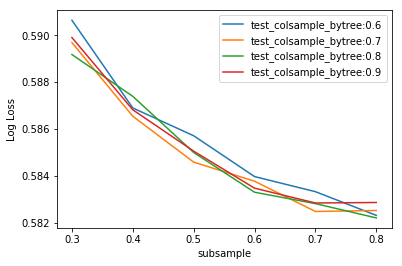

In [9]:
# summarize results
print("Best: %f using %s" % (gsearch.best_score_, gsearch.best_params_))
test_means = gsearch.cv_results_[ 'mean_test_score' ]
test_stds = gsearch.cv_results_[ 'std_test_score' ]
train_means = gsearch.cv_results_[ 'mean_train_score' ]
train_stds = gsearch.cv_results_[ 'std_train_score' ]

pd.DataFrame(gsearch.cv_results_).to_csv('my_preds_subsampleh_colsample_bytree_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(colsample_bytree), len(subsample))
train_scores = np.array(train_means).reshape(len(colsample_bytree), len(subsample))

for i, value in enumerate(colsample_bytree):
    pyplot.plot(subsample, -test_scores[i], label= 'test_colsample_bytree:'   + str(value))
#for i, value in enumerate(min_child_weight):
#    pyplot.plot(max_depth, train_scores[i], label= 'train_min_child_weight:'   + str(value))
    
pyplot.legend()
pyplot.xlabel( 'subsample' )                                                                                                      
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'subsample_vs_colsample_bytree1.png' )